In [ ]:
!pip install numpy matplotlib
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 19.3 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import gc
import torch

import rasterio
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tci_folder_path = '/content/drive/MyDrive/image_matching/TCI'
tci_files = [f for f in os.listdir(tci_folder_path)]

img1 = cv2.imread(os.path.join(tci_folder_path, tci_files[0]))
img2 = cv2.imread(os.path.join(tci_folder_path, tci_files[1]))
img3 = cv2.imread(os.path.join(tci_folder_path, tci_files[2]))

In [ ]:
def downsample_image(image, scale=0.1):
    """
    Downsample the input image by a specified scale factor.

    Args:
        image (np.array): The input image to downsample.
        scale (float, optional): The scale factor to resize the image. Defaults to 0.1.

    Returns:
        np.array: The downsampled image.
    """
    height, width = image.shape[:2]  # Get image dimensions (height and width)
    new_dimensions = (int(width * scale), int(height * scale))  # Calculate new dimensions based on scale
    return cv2.resize(image, new_dimensions, interpolation=cv2.INTER_AREA)  # Resize with INTER_AREA interpolation


def normalize_image(image):
    """
    Normalize the pixel values of an image and convert them to uint8 format.

    Args:
        image (np.array): The input image to normalize.

    Returns:
        np.array: The normalized image with pixel values between 0 and 255.
    """
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')  # Normalize and convert to uint8


# Downsample the images
img1 = downsample_image(normalize_image(img1), scale=0.2)
img2 = downsample_image(normalize_image(img2), scale=0.2)
img3 = downsample_image(normalize_image(img3), scale=0.2)

Flann Based Matcher

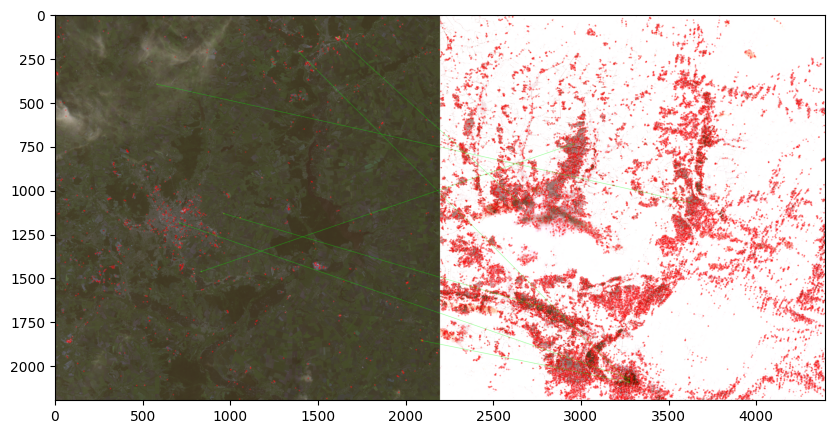

Number of matched keypoints: 7


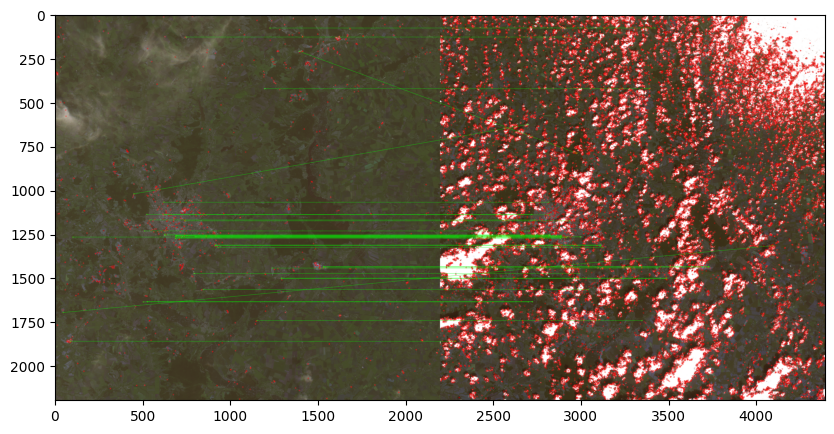

Number of matched keypoints: 42


In [ ]:
# FLANN matcher function with matched keypoints count
def flannMatcher_opencv(img1, img2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    matchesMask = [[0, 0] for i in range(len(matches))]
    good_matches = 0  # To count the number of good matches

    # Ratio test to find good matches
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            matchesMask[i] = [1, 0]
            good_matches += 1  # Increment the count for each good match

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=cv2.DrawMatchesFlags_DEFAULT)

    img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

    plt.figure(figsize=(10, 5))
    plt.imshow(img3)
    plt.show()

    print(f"Number of matched keypoints: {good_matches}")  # Print the count of good matches

    del img3
    gc.collect()

# Perform matching and print matched keypoints count
flannMatcher_opencv(img1, img2)
flannMatcher_opencv(img1, img3)

# LightGlue

In [ ]:
!git clone https://github.com/cvg/LightGlue.git
!python -m pip install -e LightGlue/

Cloning into 'LightGlue'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 382 (delta 143), reused 85 (delta 80), pack-reused 179 (from 1)
Receiving objects: 100% (382/382), 17.42 MiB | 18.92 MiB/s, done.
Resolving deltas: 100% (235/235), done.
Obtaining file:///content/LightGlue
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.4 MB/s eta 0:00:00
  Building editable for lightglue (pyproject.toml) ... done
  Created wheel for lightglue: filename=lightglue-0.0-0.editable-py3-none-any.whl size=14669 sha256=71190de86278b7577d34ffb7fbc5690d0da398a7d18d071b3192542ef3e984cd
  Stored in directory:

In [ ]:
from LightGlue.lightglue import viz2d
from LightGlue.lightglue import LightGlue, SuperPoint, DISK
from LightGlue.lightglue.utils import numpy_image_to_torch, rbd

/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/content/LightGlue/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [ ]:
class cfg:
    """Configuration class for setting up parameters related to the LightGlue framework,
    feature extraction, and keypoint matching."""

    lightglue = {
        "extractor": "SuperPoint",  # Feature extractor type: SuperPoint or DISK
        "device": "cpu",  # Device for running the extractor and matcher (e.g., "cpu" or "cuda")
        "max_kpts": 2048,  # Maximum number of keypoints to extract
        "homography": {
            "method": cv2.RANSAC,  # Method used for homography estimation (RANSAC algorithm)
            "ransacReprojThreshold": 3.0  # Reprojection threshold for RANSAC
        }
    }

In [ ]:
def preprocess_lightglue(img):
    """Preprocess the input image by converting it from a NumPy array to a PyTorch tensor."""
    img = numpy_image_to_torch(img)
    return img


def match_lightglue(img0, img1, cfg):
    """
    Extract and match keypoints between two images using the LightGlue framework and a specified feature extractor.

    Args:
        img0 (np.array): The first input image.
        img1 (np.array): The second input image.
        cfg (dict): Configuration dictionary that contains the feature extractor type ('SuperPoint' or 'DISK'),
                    the maximum number of keypoints, and the device for processing (e.g., 'cpu' or 'cuda').

    Returns:
        dict: A dictionary containing the following information:
            - "points0" (torch.Tensor): The matched keypoints in the first image.
            - "points1" (torch.Tensor): The matched keypoints in the second image.
            - "matches01" (dict): The full match information including matches and pruning.
            - "matches" (torch.Tensor): The indices of matched keypoints between img0 and img1.
            - "kpts0" (torch.Tensor): The keypoints extracted from img0.
            - "kpts1" (torch.Tensor): The keypoints extracted from img1.
            - "img0" (torch.Tensor): The preprocessed img0.
            - "img1" (torch.Tensor): The preprocessed img1.
    """
    # Preprocess both images
    img0 = preprocess_lightglue(img0)
    img1 = preprocess_lightglue(img1)

    # Load the appropriate feature extractor and matcher based on the configuration
    if cfg["extractor"] == "SuperPoint":
        extractor = SuperPoint(max_num_keypoint=cfg["max_kpts"]).eval().to(cfg["device"])
        matcher = LightGlue(features='superpoint').eval().to(cfg["device"])

    if cfg["extractor"] == "DISK":
        extractor = DISK(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])
        matcher = LightGlue(features='disk').eval().to(cfg["device"])

    # Extract local features from both images
    feats0 = extractor.extract(img0)
    feats1 = extractor.extract(img1)

    # Match the extracted features
    matches01 = matcher({'image0': feats0, 'image1': feats1})

    # Remove batch dimension from the feature and match tensors
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]

    # Get keypoints and matched points
    kpts0 = feats0["keypoints"]
    kpts1 = feats1["keypoints"]
    matches = matches01['matches']  # indices with shape (K, 2)
    points0 = kpts0[matches[..., 0]]  # matched coordinates in img0
    points1 = kpts1[matches[..., 1]]  # matched coordinates in img1

    # Return all results in a dictionary
    return {
        "points0": points0,
        "points1": points1,
        "matches01": matches01,
        "matches": matches,
        "kpts0": kpts0,
        "kpts1": kpts1,
        "img0": img0,
        "img1": img1
    }


def visualize_lightglue(img0, img1, points0, points1, kpts0, kpts1, matches01, plt_key=True, rotation=0, **kwargs):
    """Visualize the keypoints and matches between two images using the LightGlue framework."""
    # Plot the two images side by side
    axes = viz2d.plot_images([img0, img1], dpi=70)

    # Plot the matches between keypoints
    viz2d.plot_matches(points0, points1, color='lime', lw=0.2)

    # Add labels to the images
    viz2d.add_text(0, f'Img1', fs=20)
    viz2d.add_text(1, f'Img2: Rotation {rotation} deg.', fs=20)

    # Optionally plot the keypoints with color pruning
    if plt_key:
        kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
        viz2d.plot_images([img0, img1], dpi=70)
        viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /root/.cache/torch/hub/checkpoints/superpoint_v1.pth
100%|██████████| 4.96M/4.96M [00:00<00:00, 103MB/s]
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /root/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth
100%|██████████| 45.3M/45.3M [00:00<00:00, 111MB/s]


CPU times: user 41.8 s, sys: 12 s, total: 53.8 s
Wall time: 1min 1s
Number of matched keypoints:  199


70

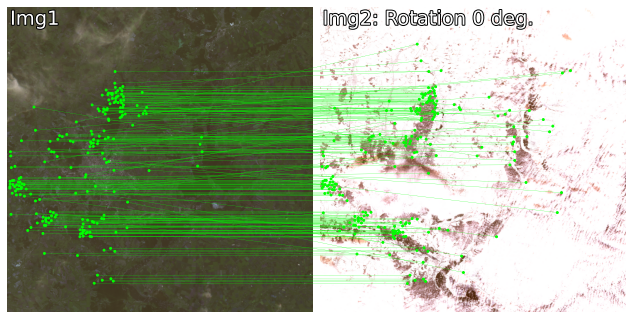

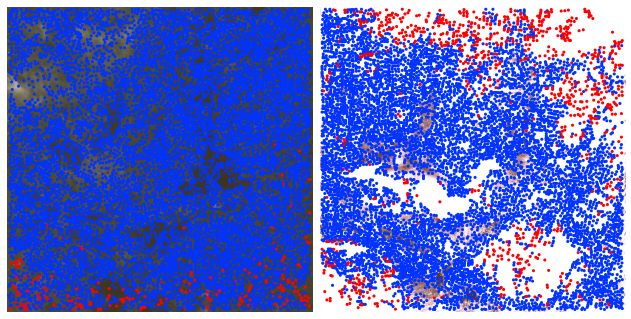

In [ ]:
# no_snow/no_clouds matching to snow/no_clouds
%time results_lightglue = match_lightglue(img1, img2, cfg.lightglue)
visualize_lightglue(**results_lightglue)

print(f'Number of matched keypoints: ', len(results_lightglue['matches01']['matches']))

del results_lightglue
gc.collect()

CPU times: user 48.7 s, sys: 11 s, total: 59.7 s
Wall time: 1min 2s
Number of matched keypoints:  121


10374

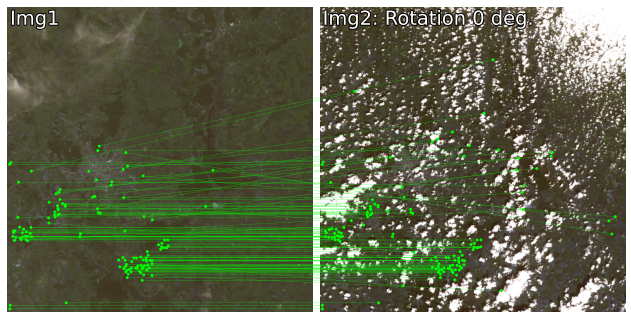

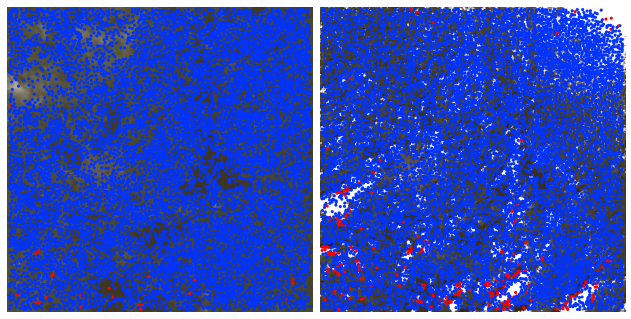

In [ ]:
# no_snow/no_clouds matching to no_snow/clouds
%time results_lightglue = match_lightglue(img1, img3, cfg.lightglue)
visualize_lightglue(**results_lightglue)

print(f'Number of matched keypoints: ', len(results_lightglue['matches01']['matches']))

del results_lightglue
gc.collect()

ALIKED

In [ ]:
!pip install git+https://github.com/cvg/LightGlue.git

  Cloning https://github.com/cvg/LightGlue.git to /tmp/pip-req-build-yo2ook1e
  Running command git clone --filter=blob:none --quiet https://github.com/cvg/LightGlue.git /tmp/pip-req-build-yo2ook1e
  Resolved https://github.com/cvg/LightGlue.git to commit edb2b838efb2ecfe3f88097c5fad9887d95aedad
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lightglue: filename=lightglue-0.0-py3-none-any.whl size=39499 sha256=679b1f30cede53b05dfa3f6a2c1b62e5f6e6ace23db58b3b992a6de53dd587b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-hizvngqt/wheels/07/dc/a1/22bc17d3d78e58fbd145e264d6736aab70959fbf872c80ddb9
Successfully built lightglue
  Attempting uninstall: lightglue
    Found existing installation: lightglue 0.0
    Uninstalling lightglue-0.0:
      Successfully uninstalled lightglue-0.0


In [ ]:
from lightglue import match_pair
from lightglue import ALIKED, LightGlue
from lightglue.utils import load_image, rbd
import kornia as K  # Kornia for image processing in PyTorch

In [ ]:
def numpy_to_torch_image(np_img, device=torch.device('cpu')):
    """Convert a NumPy array to a PyTorch tensor."""
    # Convert images to PyTorch tensors
    torch_img = torch.from_numpy(np_img).float() / 255.0
    torch_img = torch_img.permute(2, 0, 1).unsqueeze(0)  # Change to (C, H, W) and add batch dim
    return torch_img.to(device)

In [ ]:
def perform_matching(img1, img2, device):
    """Extract features and match keypoints between two images."""
    # Convert images to PyTorch tensors
    image0 = numpy_to_torch_image(img1, device=device)
    image1 = numpy_to_torch_image(img2, device=device)

    # Initialize the ALIKED extractor and LightGlue matcher
    extractor = ALIKED(max_num_keypoints=4096, detection_threshold=0.01).eval().to(device)
    matcher = LightGlue(features='aliked').eval().to(device)

    # Perform matching
    with torch.inference_mode():
        feats0, feats1, matches01 = match_pair(extractor, matcher, image0, image1)

    # Print the number of matched keypoints
    num_matches = len(matches01["matches"])
    print(f'Number of matched keypoints: {num_matches}')

    return feats0, feats1, matches01, image0, image1, num_matches

In [ ]:
def visualize_matches(feats0, feats1, matches01, image0, image1):
    """Visualize the matches between two images using keypoints."""
    # Extract keypoints and matches
    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

    # Convert images from GPU to CPU and NumPy
    image0_np = image0.squeeze().permute(1, 2, 0).cpu().numpy()
    image1_np = image1.squeeze().permute(1, 2, 0).cpu().numpy()

    # Plot the images
    axes = viz2d.plot_images([image0_np, image1_np])

    # Plot the matches between keypoints
    viz2d.plot_matches(m_kpts0.cpu().numpy(), m_kpts1.cpu().numpy(), color="lime", lw=0.2)

    # Add text to the plot
    viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

    # Plot keypoints with color maps
    kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
    viz2d.plot_images([image0_np, image1_np])
    viz2d.plot_keypoints([kpts0.cpu().numpy(), kpts1.cpu().numpy()], colors=[kpc0, kpc1], ps=10)
    plt.show()

In [ ]:
def match_and_visualize(img1, img2):
    """Perform matching and visualize the results for two images."""
    # Set the device (use GPU if available)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Perform matching
    feats0, feats1, matches01, image0, image1, num_matches = perform_matching(img1, img2, device)

    # Visualize the matches
    visualize_matches(feats0, feats1, matches01, image0, image1)

Number of matched keypoints: 1019


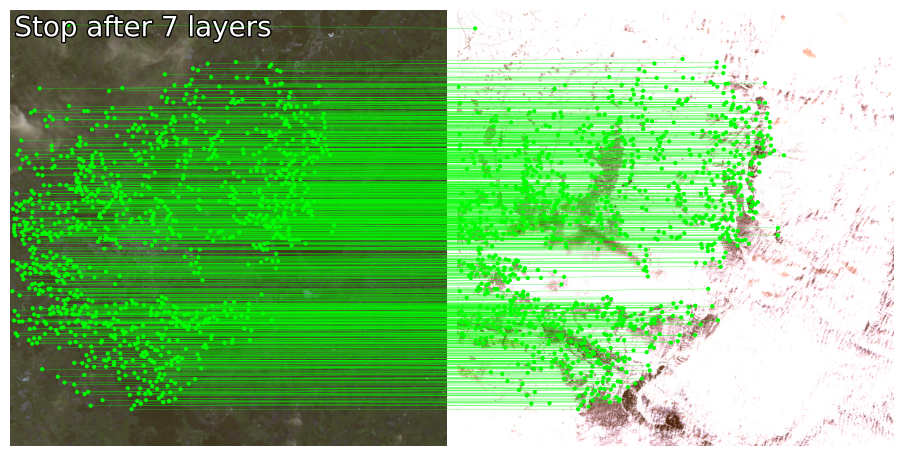

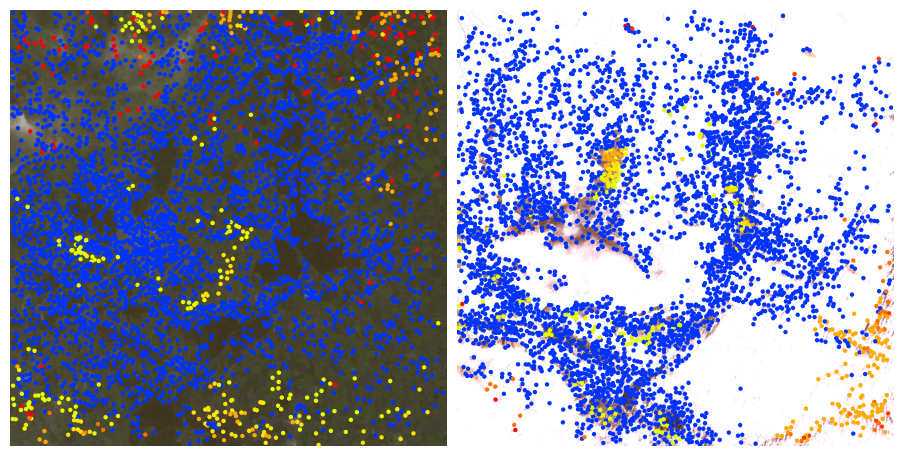

In [ ]:
match_and_visualize(img1, img2)

Number of matched keypoints: 419


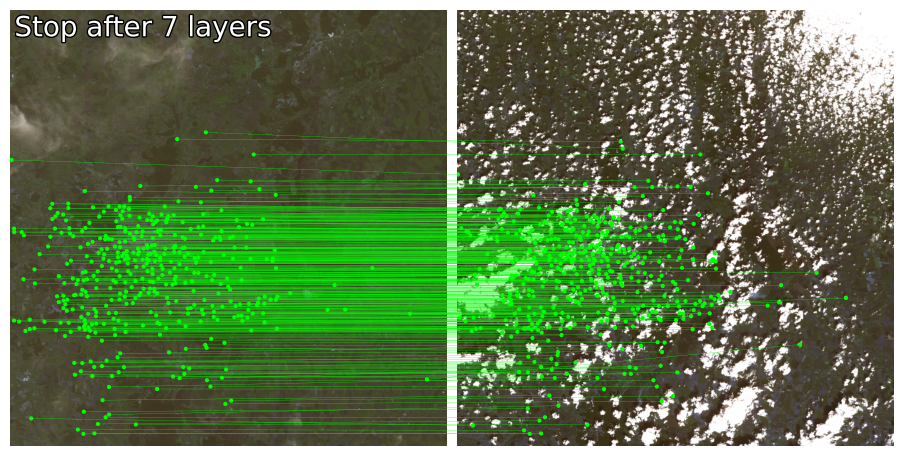

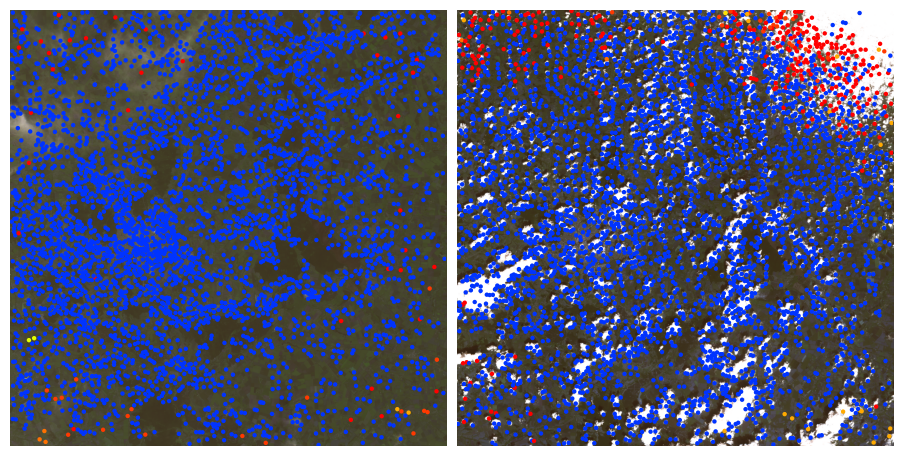

In [ ]:
match_and_visualize(img1, img3)